In [1]:
#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *

In [2]:
#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *

In [3]:
print(os.getcwd())
data_file_name = "out_csv/testing_out.csv"
samples_per_sequence = 3

In [4]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name, samples_per_sequence)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

In [5]:
len(signals)

9

In [6]:
plt.figure(figsize=(30, 10))
i  = 1
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

len(signals)

9

In [7]:
#Create a "SignalDataset" class by importing the Pytorch Dataset class
class Dataset_ctc(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, x,y):
        self.x_data = x
        self.y_data = y

    #called by the dataLOADER class whenever it wants a new mini-batch
    #returns corresponding input datapoints AND the corresponding labels
    def __getitem__(self, index):
        return {'audio': np.array(self.x_data[0]), 'text': np.array(self.y_data[0]), 'sample_rate': 22050}
        
    #length of the dataset
    def __len__(self):
        return len(self.x_data)

In [8]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [9]:
config

{'dataset': {'root': 'DB/LJspeech',
  'train_part': 0.95,
  'name': 'ljspeech',
  'sample_rate': 22050},
 'bpe': {'train': True, 'model_path': 'yttm.bpe'},
 'train': {'seed': 42,
  'num_workers': 1,
  'batch_size': 8,
  'clip_grad_norm': 15,
  'epochs': 42,
  'optimizer': {'lr': 0.0005, 'weight_decay': 0.0001}},
 'wandb': {'project': 'quartznet_ljspeech', 'log_interval': 20},
 'model': {'name': '_quartznet5x5_config', 'vocab_size': 120, 'feat_in': 64}}

In [10]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get('sample_rate', 16000),
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    MaskSpectrogram(
        probability=0.5,
        time_mask_max_percentage=0.05,
        frequency_mask_max_percentage=0.15
    ),
    AddLengths(),
    Pad()
])

# transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
# ])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get(
            'sample_rate', 16000),  # for LJspeech
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad() # pad both audio and text
])

# load datasets
train_dataset = dataset_module.get_dataset(
    config, transforms=transforms_train, part='train')
val_dataset = dataset_module.get_dataset(
    config, transforms=transforms_val, part='val')
# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)

# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe)

prev_wer = 1000
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

In [11]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get('sample_rate', 16000),
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    MaskSpectrogram(
        probability=0.5,
        time_mask_max_percentage=0.05,
        frequency_mask_max_percentage=0.15
    ),
    AddLengths(),
    Pad()
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get(
            'sample_rate', 16000),  # for LJspeech
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad() # pad both audio and text
])

# load datasets
train_dataset = dataset_module.get_dataset(
    config, transforms=transforms_train, part='train')
val_dataset = dataset_module.get_dataset(
    config, transforms=transforms_val, part='val')
# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)

# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe)

prev_wer = 1000
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

[]

In [12]:
a=next(iter(train_dataloader))

In [13]:
a=next(iter(train_dataloader))
a

{'audio': [tensor([[-7.3242e-04, -7.6294e-04, -6.4087e-04,  ...,  7.3242e-04,
            2.1362e-04,  6.1035e-05]]),
  tensor([[-0.0003,  0.0000,  0.0000,  ..., -0.0009, -0.0010, -0.0011]]),
  tensor([[-0.0025, -0.0037,  0.0005,  ...,  0.0003,  0.0002, -0.0004]]),
  tensor([[ 0.0002,  0.0000, -0.0002,  ..., -0.0006, -0.0006, -0.0007]]),
  tensor([[0.0004, 0.0005, 0.0004,  ..., 0.0005, 0.0006, 0.0008]]),
  tensor([[6.1035e-05, 2.1362e-04, 1.5259e-04,  ..., 7.3242e-04, 7.0190e-04,
           7.3242e-04]]),
  tensor([[ 2.7466e-04, -3.0518e-05,  3.9673e-04,  ...,  3.0518e-04,
            3.0518e-05, -1.2207e-04]]),
  tensor([[ 2.2583e-03,  1.7700e-03, -9.1553e-05,  ...,  1.8311e-04,
           -1.8311e-04, -3.3569e-04]])],
 'text': ['Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition',
  'in being comparatively modern.',
  'For although the Chinese took impressions from wood blocks engrave

In [14]:
type(config)

easydict.EasyDict

In [15]:
config

{'dataset': {'root': 'DB/LJspeech',
  'train_part': 0.95,
  'name': 'ljspeech',
  'sample_rate': 22050},
 'bpe': {'train': True, 'model_path': 'yttm.bpe'},
 'train': {'seed': 42,
  'num_workers': 1,
  'batch_size': 8,
  'clip_grad_norm': 15,
  'epochs': 42,
  'optimizer': {'lr': 0.0005, 'weight_decay': 0.0001}},
 'wandb': {'project': 'quartznet_ljspeech', 'log_interval': 20},
 'model': {'vocab_size': 120, 'feat_in': 64}}

In [16]:
config.dataset

{'root': 'DB/LJspeech',
 'train_part': 0.95,
 'name': 'ljspeech',
 'sample_rate': 22050}

In [17]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get('sample_rate', 16000),
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    MaskSpectrogram(
        probability=0.5,
        time_mask_max_percentage=0.05,
        frequency_mask_max_percentage=0.15
    ),
    AddLengths(),
    Pad()
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get(
            'sample_rate', 16000),  # for LJspeech
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad() # pad both audio and text
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
val_dataset = dataset_module.get_dataset(
    config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)

# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe)

prev_wer = 1000
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))

In [18]:
#! Tin 
from IPython.display import clear_output  
import randomizeSequence as rSeq
import ScrappySequence as ss
import math
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

#!/usr/bin/env python
import os
import json
import time
import argparse
from tqdm import tqdm
from collections import defaultdict
import math
import argparse
import importlib

# torchim:
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset, ConcatDataset
# from tensorboardX import SummaryWriter
import numpy as np
import pytorch_warmup as warmup

# data:
import data
from data.collate import collate_fn, gpu_collate, no_pad_collate
from data.transforms import (
    Compose, AddLengths, AudioSqueeze, TextPreprocess,
    MaskSpectrogram, ToNumpy, BPEtexts, MelSpectrogram,
    ToGpu, Pad, NormalizedMelSpectrogram
)
import youtokentome as yttm

import torchaudio
from audiomentations import (
    TimeStretch, PitchShift, AddGaussianNoise
)
from functools import partial

# model:
from model import configs as quartznet_configs
from model.quartznet import QuartzNet

# utils:
import yaml
from easydict import EasyDict as edict
from utils import fix_seeds, remove_from_dict, prepare_bpe
import wandb
from decoder import GreedyDecoder, BeamCTCDecoder

import youtokentome as yttm
from gen_data_func import *

In [19]:
print(os.getcwd())
data_file_name = "out_csv/testing_out.csv"
samples_per_sequence = 3

In [20]:
start = time.monotonic()
signals,index,spacer_labels, letter_labels, barcode_labels, ctc_labels =prepare_train2(data_file_name, samples_per_sequence)
end = time.monotonic()
print(f"Generated {len(signals)} signals and {len(spacer_labels)} labels", f"in {end-start}")
#Sequential: 26.099690708000026

In [21]:
len(signals)

9

In [22]:
plt.figure(figsize=(30, 10))
i  = 1
plt.plot(signals[i])
plt.plot(spacer_labels[i])
print("Letters:", letter_labels[i], "\nbarcodes:", barcode_labels[i], '\nctc_labels:', ctc_labels[i])

len(signals)

9

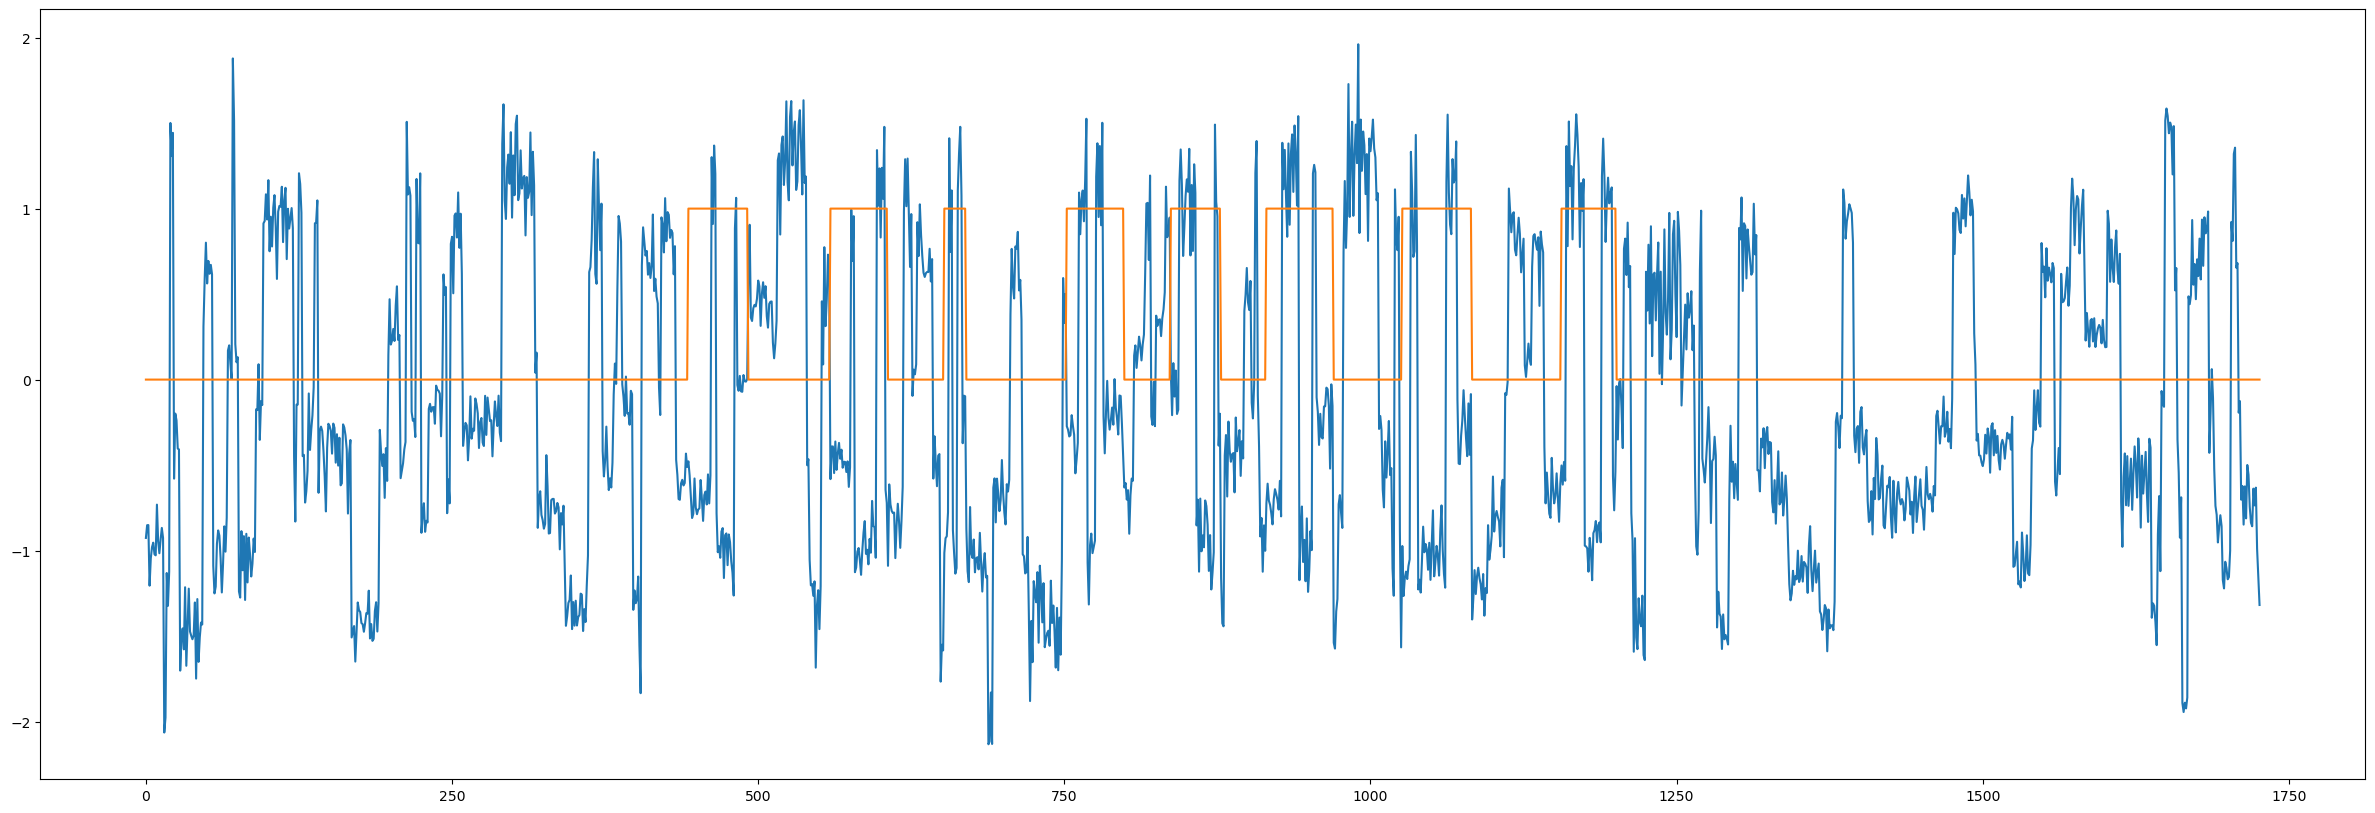

In [23]:
#Create a "SignalDataset" class by importing the Pytorch Dataset class
class Dataset_ctc(Dataset):
    """ Data noisey sinewave dataset
        num_datapoints - the number of datapoints you want
    """
    def __init__(self, x,y):
        self.x_data = x
        self.y_data = y

    #called by the dataLOADER class whenever it wants a new mini-batch
    #returns corresponding input datapoints AND the corresponding labels
    def __getitem__(self, index):
        return {'audio': np.array(self.x_data[0]), 'text': np.array(self.y_data[0]), 'sample_rate': 22050}
        
    #length of the dataset
    def __len__(self):
        return len(self.x_data)

In [24]:

# TODO: wrap to trainer class

parser = argparse.ArgumentParser(description='Training model.')
parser.add_argument('--config', default='configs/train_LJSpeech.yaml',
                    help='path to config file')
args = parser.parse_args("")
with open(args.config, 'r') as f:
    config = edict(yaml.safe_load(f))

def write_to_file(str_w, file_name = 'sth.txt', mode = 'w'):
    with open(file_name,mode) as f:
        f.write(str(str_w))

In [25]:
config

{'dataset': {'root': 'DB/LJspeech',
  'train_part': 0.95,
  'name': 'ljspeech',
  'sample_rate': 22050},
 'bpe': {'train': True, 'model_path': 'yttm.bpe'},
 'train': {'seed': 42,
  'num_workers': 1,
  'batch_size': 8,
  'clip_grad_norm': 15,
  'epochs': 42,
  'optimizer': {'lr': 0.0005, 'weight_decay': 0.0001}},
 'wandb': {'project': 'quartznet_ljspeech', 'log_interval': 20},
 'model': {'name': '_quartznet5x5_config', 'vocab_size': 120, 'feat_in': 64}}

In [26]:
fix_seeds(seed=config.train.get('seed', 42))
dataset_module = importlib.import_module(
    f'.{config.dataset.name}', data.__name__)
bpe = prepare_bpe(config)

transforms_train = Compose([
    # TextPreprocess(),# removing punctuation in text - might not needed
    # ToNumpy(), # convert audio to numpy
    # BPEtexts(bpe=bpe, dropout_prob=config.bpe.get('dropout_prob', 0.05)),
    # AudioSqueeze(), # remove 1st dimension if it is 1 [1,...]
    # AddGaussianNoise(
    #     min_amplitude=0.001,
    #     max_amplitude=0.015,
    #     p=0.5
    # ),
    # TimeStretch(
    #     min_rate=0.8,
    #     max_rate=1.25,
    #     p=0.5
    # ),
    # PitchShift(
    #     min_semitones=-4,
    #     max_semitones=4,
    #     p=0.5
    # )
    # AddLengths()
])

batch_transforms_train = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get('sample_rate', 16000),
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    MaskSpectrogram(
        probability=0.5,
        time_mask_max_percentage=0.05,
        frequency_mask_max_percentage=0.15
    ),
    AddLengths(),
    Pad()
])

transforms_val = Compose([
#     TextPreprocess(),
#     ToNumpy(),
#     BPEtexts(bpe=bpe),
#     AudioSqueeze()
])

batch_transforms_val = Compose([
    ToGpu('cuda' if torch.cuda.is_available() else 'cpu'),
    NormalizedMelSpectrogram(
        sample_rate=config.dataset.get(
            'sample_rate', 16000),  # for LJspeech
        n_mels=config.model.feat_in,
        normalize=config.dataset.get('normalize', None)
    ).to('cuda' if torch.cuda.is_available() else 'cpu'),
    AddLengths(),
    Pad() # pad both audio and text
])

# load datasets
# train_dataset = dataset_module.get_dataset(
#     config, transforms=transforms_train, part='train')
val_dataset = dataset_module.get_dataset(
    config, transforms=transforms_val, part='val')

# ! TIN Dataset
train_dataset = Dataset_ctc(signals,ctc_labels)

# print("!!!", config.train.get('num_workers', 4))
train_dataloader = DataLoader(train_dataset, 
                                batch_size=config.train.get('batch_size', 1), collate_fn=no_pad_collate)

val_dataloader = DataLoader(val_dataset, 
                            batch_size=1, collate_fn=no_pad_collate)

print(getattr(quartznet_configs, config.model.name, '_quartznet5x5_config'))

model = QuartzNet(
    model_config=getattr(
        quartznet_configs, config.model.name, '_quartznet5x5_config'),
    **remove_from_dict(config.model, ['name'])
)

# print(model)
write_to_file(model,'model_structure.txt')

optimizer = torch.optim.Adam(
    model.parameters(), **config.train.get('optimizer', {}))
num_steps = len(train_dataloader) * config.train.get('epochs', 10)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_steps)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

if config.train.get('from_checkpoint', None) is not None:
    model.load_weights(config.train.from_checkpoint)

if torch.cuda.is_available():
    model = model.cuda()

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
# criterion = nn.CTCLoss(blank=config.model.vocab_size)
decoder = GreedyDecoder(bpe=bpe)

prev_wer = 1000
wandb.init(project=config.wandb.project, config=config)
wandb.watch(model, log="all", log_freq=config.wandb.get(
    'log_interval', 5000))